implement and compare:
- Decision tree
- Naive Bayes
- K-means clustering
- DBSCAN

sklearn only:
- Multi-layer Perceptron
- KNN
- SVM
- Random Forest
- Agglomerative Clustering

classification metrics:
- precision
- recall
- F1-score
- accuracy
- confusion matrices

clustering evaluation:
- RAIN CHECK (may require admission of mistake in proposal)

TODO:
- deal with plot_data using ALL the data, i.e. don't test on the training data

In [1]:
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

from scipy.stats import mode

import numpy as np

from DecisionTree import *
from NaiveBayes import *

In [2]:
iris = load_iris()

In [3]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [4]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [5]:
# modified from:
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py
def plot_data(classifier = None):
  plot_colors = "ryb"
  plot_step = 0.02
  n_classes = 3

  for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # subplots
    plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0, w_pad=0, pad=0)

    # optional classifier for optional decision boundary
    if classifier is not None:
      clf = classifier().fit(X, y) # train
      x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
      y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
      xx, yy = np.meshgrid(
          np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
      )
      Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
      Z = Z.reshape(xx.shape)
      cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=iris.target_names[i],
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )
  
  fig = plt.gcf()
  fig.set_size_inches(18, 9)
  plt.legend(loc="lower right", borderpad=0, handletextpad=0)
  plt.axis("tight")

  plt.show()

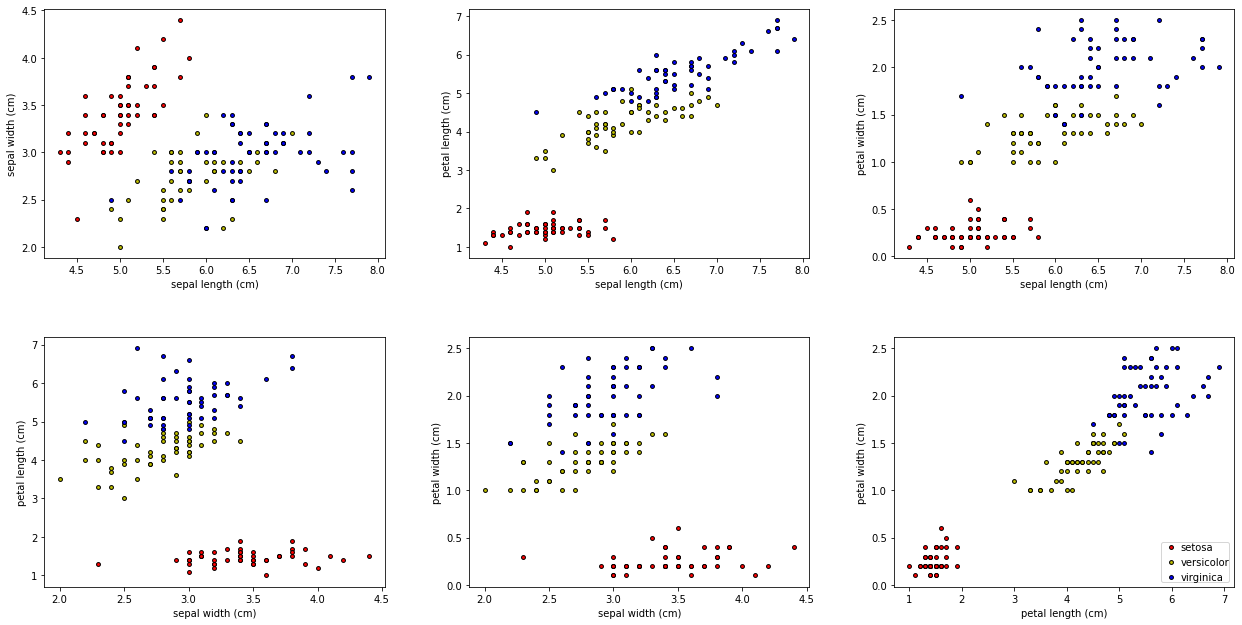

In [6]:
plot_data()

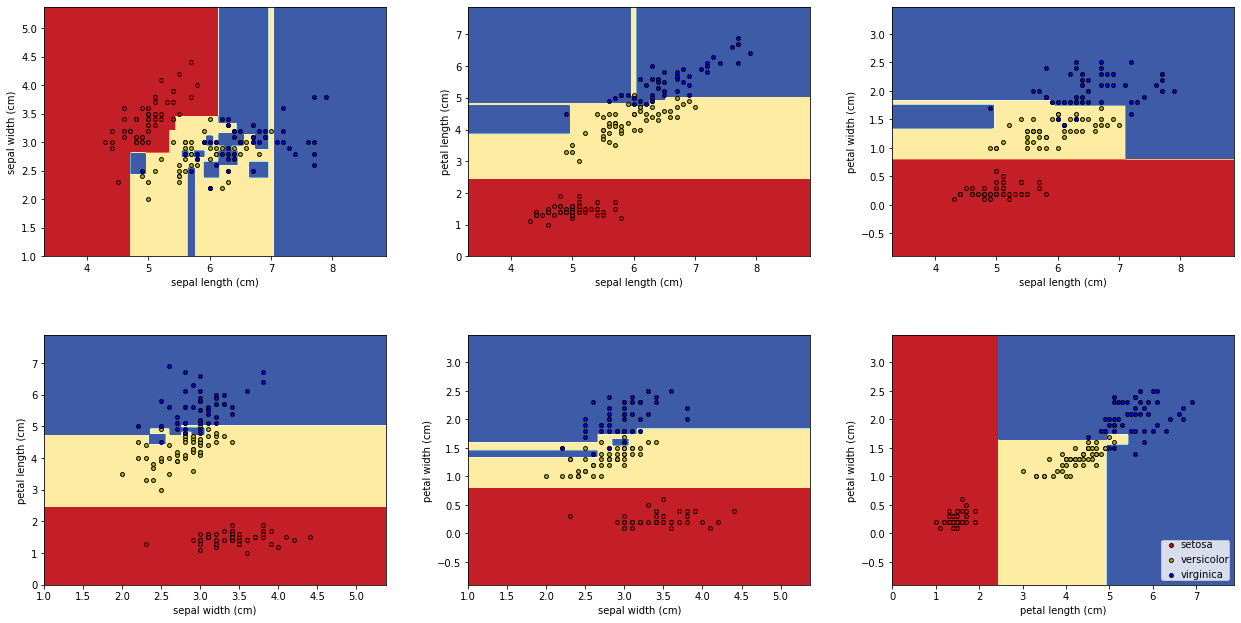

In [7]:
# decision tree
plot_data(DecisionTreeClassifier)

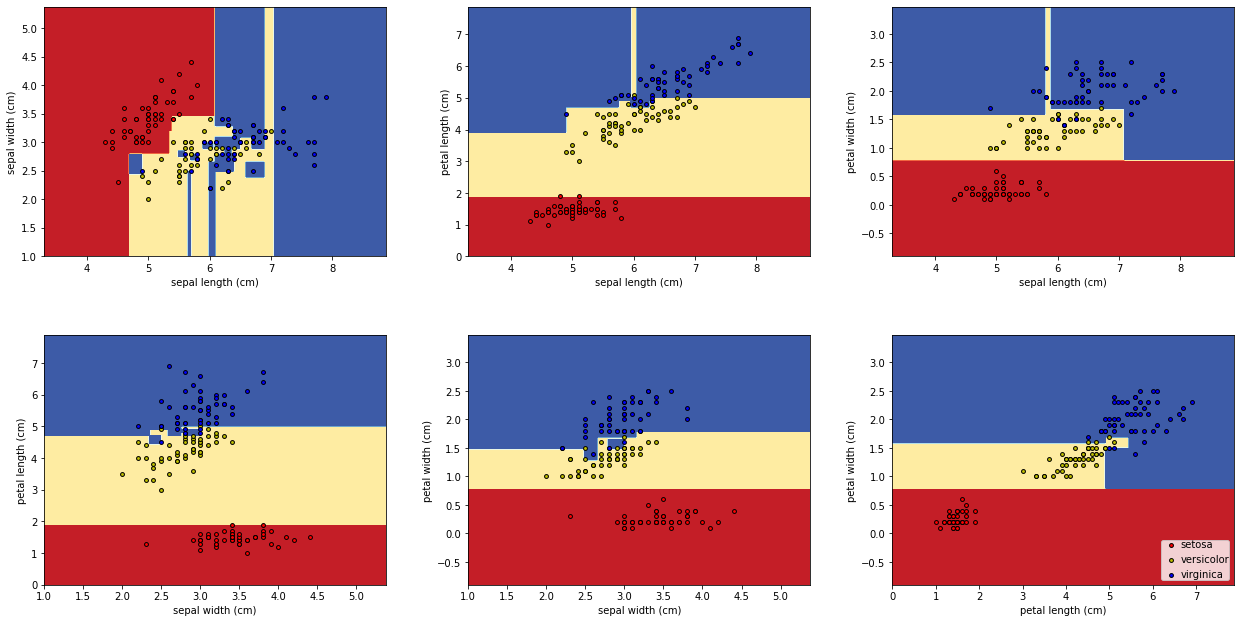

In [8]:
plot_data(SimpleDecisionTree)

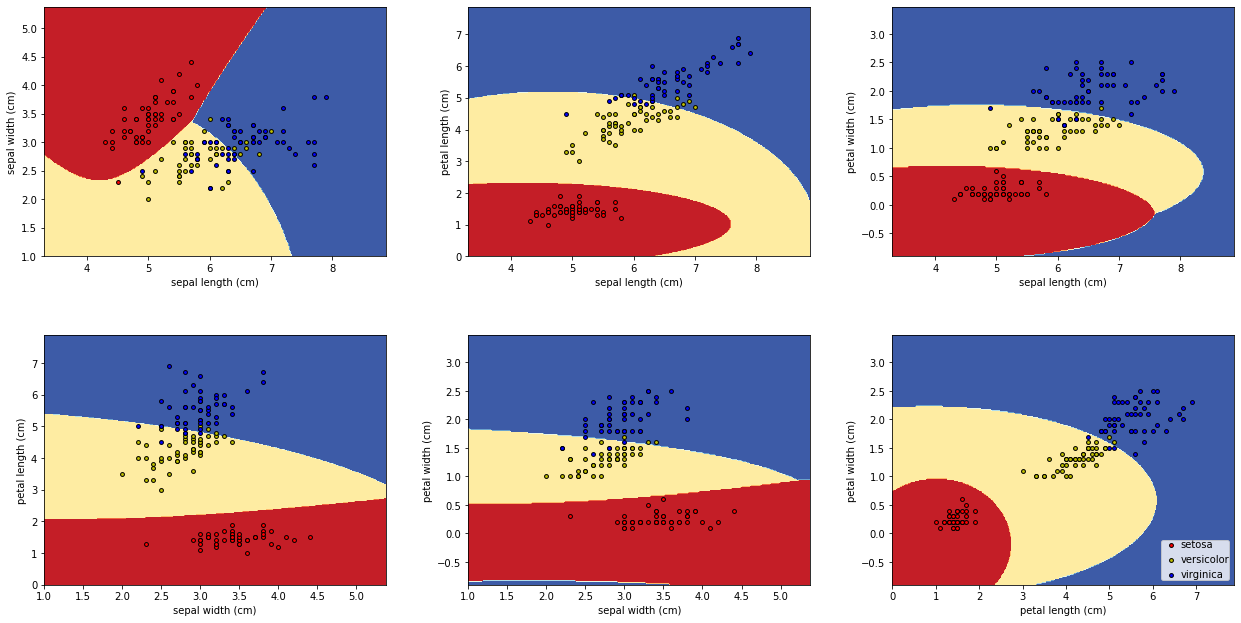

In [9]:
# naive bayes
plot_data(GaussianNB)

TypeError: cannot unpack non-iterable numpy.int64 object

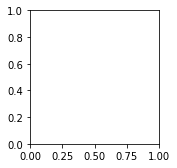

In [10]:
plot_data(SimpleNaiveBayes)

In [ ]:
# multi-layer perceptron
plot_data(MLPClassifier)

In [ ]:
# k nearest neighbors
plot_data(KNeighborsClassifier)

In [ ]:
# support vector machine
plot_data(LinearSVC)

In [ ]:
# random forest
plot_data(RandomForestClassifier)